In [2]:
# import packages

import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
import cvxpy 
import numpy as np
from scipy import linalg
import math

In [3]:
# constants for spin detection 

rho = 1.29
C_M = 0.6
C_D = 0.4
r = 0.02
g = 9.81
m = 2.7
A = math.pi * r**2
time_step = 1/60
p = 2.7432/1120
k_M = 0.5 * C_M * rho * A * r
k_D = -0.5 * C_D * rho

In [6]:
# initialize network and read in images. note that the weights for the code is included in repo
net = cv2.dnn.readNet("yolov3_training_last.weights", "yolov3_testing.cfg")
classes = ["object"]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# ensure that the file 'frames' is populated with images directly imported from vidToImgs.ipynb
images_path = glob.glob(r".\val\*.jpg")
sorted_img = sorted(images_path, key = lambda x: int(x.split("\\")[-1].strip(".jpg")))
x_axis =[]
y_axis=[]

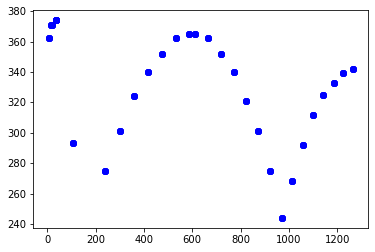

In [11]:
# loop CNN through images

count = 0
for img_path in sorted_img:
    # Loading image
    img = cv2.imread(img_path)
#     img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)
    # Showing informations on the screen
    preds = np.concatenate(outs,axis=0)
    bestPred = np.argmax(preds[:,5])
    detection = preds[bestPred]
    confidence = detection[5]
    
    if confidence > 0.3:
        centre_x = int(detection[0] * width)
        centre_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)
        x = int(centre_x - w / 2)
        y = int(centre_y - h / 2)
        x_axis.append(x)
        y_axis.append(height-y)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0,0,0), 2)
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, 'Ball', (x, y), font, 1, (0,0,0), 2)
    
    # display results
    cv2.imshow("Image", img)
    cv2.imwrite("./detected2/%d.jpg" % count, img)  
    count +=1
    key = cv2.waitKey(1)

# print plot. note that the plat is x vs. y in units of PIXELS. to convert to x vs. time, 
# appropriate modifications must be made. 
plt.plot(x_axis, y_axis,'bo')
plt.savefig('plo.jpg')
cv2.destroyAllWindows()   

In [ ]:
# We're missing a cruical step: Using the function above to extract the 3d coordinates of the ball.
# The code below can be run if there are valid arrays x_axis, y_axis, and z_axis, which describe the 
# ball's position with respect to time. The code above only produces a 2d projection with axes in 
# pixels. A coordinate transformation is needed, but time ran out for the project. To whoever's reading
# this, pls figure it out and contact us!

In [9]:
# produces a least-squares cubic fit for 3D position of ball
def cubicRegress(coords, time_step):
    times = np.zeros(len(coords))
    for i in range(len(times)):
        times[i] = i * time_step
    return np.polyfit(coords, times, 3)

# gets three polynomaials and their first and second derivatives 
x_poly = cubicRegress(x_axis, time_step)  
x_prime = np.array([3*x_poly[0],2*x_poly[1],x_poly[2]])
x_dblprime = np.array([2*x_prime[0],x_prime[1]])

y_poly = cubicRegress(y_axis, time_step)  
y_prime = np.array([3*y_poly[0],2*y_poly[1],y_poly[2]])
y_dblprime = np.array([2*y_prime[0],y_prime[1]])

z_poly = cubicRegress(z_axis, time_step)  
z_prime = np.array([3*z_poly[0],2*z_poly[1],z_poly[2]])
z_dblprime = np.array([2*z_prime[0],z_prime[1]])

# begin building matrix and vector for solution 
def buildMatrix (t):
    dx = 0 
    dy = 0
    dz= 0 
    for i in range(len(x_prime)):
        dx += x_prime[i]* t**(2-i)
        dy += y_prime[i]* t**(2-i)
        dz += z_prime[i]* t**(2-i)
    a = dx* k_M/m
    b = dy* k_M/m  
    c = dz* k_M/m
    return np.array([[0,c,-b],[-c,0,a],[b,-a,0]])

def buildAcceleration (t):
    dx = 0 
    dy = 0
    dz = 0 
    for i in range(len(x_prime)):
        dx += x_prime[i]* t**(2-i)
        dy += y_prime[i]* t**(2-i)
        dz += z_prime[i]* t**(2-i)
    dx2 = 0 
    dy2 = 0
    dz2 = 0 
    for i in range(len(x_dblprime)):
        dx2 += x_dblprime[i]*t**(1-i)
        dy2 += y_dblprime[i]*t**(1-i)
        dz2 += z_dblprime[i]*t**(1-i)
    norm = math.sqrt(dx**2+dy**2+dz**2)
    a = dx2+ (norm *k_D * dx)/m
    b = dy2+ (norm *k_D * dy)/m
    c = dz2+ (norm *k_D * dz)/m - g
    return np.array([a,b,c])

times = np.zeros(len(x_axis))
for i in range(len(times)):
    times[i] = i * time_step

# solve linear equation and return rotation vector
def solveOmega():
    M = buildMatrix(0)
    acc = buildAcceleration(0)
    for i in range(1, len(times)):
        t = time_step * i
        M = np.concatenate((M,buildMatrix(t)),axis=0)
        acc = np.concatenate((acc,buildAcceleration(t)),axis=0)
    omega = np.linalg.solve(M.T@M, M.T@acc)
    print('Ball is spinning in the direction of ' + str(omega)) 

solveOmega()

Ball is spinning in the direction of [ 4.80489623e+06  5.58332166e+09 -2.92713315e+06]
